A restart of [ml_gen_parameters.ipynb](ml_gen_parameters.ipynb) but with 2k spectra instead of 16k just to make experimenting faster

In [36]:
import platform
from pathlib import Path
from copy import deepcopy
import functools

import numpy as np

from astropy import units as u
from astropy import constants as cnst
from astropy.io import fits
from astropy import modeling

from specutils import Spectrum1D, manipulation

from astropy.visualization import quantity_support
quantity_support()

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
tensor_dtype = torch.float32
if device == 'cpu':
    tensor_dtype = torch.float64
print(f"Using {device} device with dtype {tensor_dtype}")

Using cpu device with dtype torch.float64


See [resampling_tensors.ipynb](resampling_tensors.ipynb) for deriving the tensors from the spectra.  Note it doesn't perfectly match all the spectra because we are skipping the interpolated ones.

In [3]:
if device == 'cpu':
    if platform.node()=='falcata':
        torch.set_num_threads(12)  # COMPUTER DEPENDENT!
    else:
        print('unrecognized machine, using default')

# Data loading and prep

In [4]:
alltensorpaths = list(Path('resampled_tensors').glob('*_2k.pt'))
len(alltensorpaths)

7508

In [5]:
exampledata = torch.load(alltensorpaths[0], weights_only=True)
exampledata

{'header': {'SIMPLE': True,
  'BITPIX': -32,
  'NAXIS': 1,
  'NAXIS1': 1569128,
  'EXTEND': True,
  'EXTNAME': 'PRIMARY',
  'WAVE': '../../WAVE_PHOENIX-ACES-AGSS-COND-2011.fits',
  'PHXTEFF': 2300.0,
  'PHXLOGG': 0.0,
  'PHXM_H': 0.5,
  'PHXALPHA': 0.0,
  'PHXDUST': False,
  'PHXEOS': 'ACES',
  'PHXBUILD': '02/Aug/2010',
  'PHXVER': '16.01.00B',
  'DATE': '2012-03-16 15:16:21',
  'PHXXI_L': 0.0,
  'PHXXI_M': 0.0,
  'PHXXI_N': 0.0,
  'PHXMASS': 1.5802e+33,
  'PHXREFF': 10266000000000.0,
  'PHXLUM': 2.1025e+36,
  'PHXMXLEN': 1.0,
  'PHXCONV': False,
  'BUNIT': 'erg/s/cm^2/cm'},
 'wl': tensor([ 9000.0000,  9005.1295,  9010.2589,  ..., 19489.7411, 19494.8705,
         19500.0000], dtype=torch.float64),
 'flux': tensor([3.6188e+12, 3.4967e+12, 3.7870e+12,  ..., 4.2262e+12, 3.6158e+12,
         3.8995e+12], dtype=torch.float64)}

In [6]:
exampledata['flux'].shape[0]*len(alltensorpaths)*torch.float64.itemsize * 2**-30 #MB

0.11456298828125

So it all fits easily in memory (even if we just blindly load all the wls).

In [7]:
headers = []
wls = []
fluxes = []

for pth in tqdm(alltensorpaths):
    data = torch.load(pth, weights_only=True)
    headers.append(data['header'])
    wls.append(data['wl'])
    fluxes.append(data['flux'])

fluxes = torch.stack(fluxes)

  0%|          | 0/7508 [00:00<?, ?it/s]

Confirm the assumption that all the wls are identical

In [8]:
assert torch.all(torch.stack(wls)==wls[0])

Now just use a single wl

In [9]:
wl = wls[0]
del wls

In [10]:
teff = torch.tensor([h['PHXTEFF'] for h in headers])
logg = torch.tensor([h['PHXLOGG'] for h in headers])
feh = torch.tensor([h['PHXM_H'] for h in headers])

infeatures = torch.stack([teff,logg,feh], dim=1)

In [11]:
xy_ds = TensorDataset(infeatures.to(device, tensor_dtype), fluxes.to(device, tensor_dtype))
next(iter(xy_ds))

(tensor([2.3000e+03, 0.0000e+00, 5.0000e-01], dtype=torch.float64),
 tensor([3.6188e+12, 3.4967e+12, 3.7870e+12,  ..., 4.2262e+12, 3.6158e+12,
         3.8995e+12], dtype=torch.float64))

# A Basic MLP w/batchnorm on the inputs

In [12]:
class MLP(nn.Module):
    def __init__(self, in_features=3, npix_out=fluxes.shape[-1], inner_layer_nneurons=[512, 512], check_convert=False, batchnorm='firstonly'):
        super().__init__()

        prev_layern = in_features
        stack = []
        if batchnorm:
            stack.append(nn.BatchNorm1d(in_features))
            
        for nneurons in inner_layer_nneurons:
            stack.append(nn.Linear(prev_layern, nneurons))
            if batchnorm and batchnorm != 'firstonly':
                stack.append(nn.BatchNorm1d(nneurons))
            stack.append(nn.GELU())
            prev_layern = nneurons
        stack.append(nn.Linear(prev_layern, npix_out))
        
        self.stack = nn.Sequential(*stack)

        self.check_convert = check_convert

    @property
    def device(self):
        return next(self.parameters()).device         

    @property
    def dtype(self):
        return next(self.parameters()).dtype
        
    @property
    def in_features(self):
        return self.stack[0].num_features


    def convert_tensors(self, x):
        if x.device != self.device:
            x = x.to(self.device)
        if x.dtype != sefl.dtype:
            x = x.to(self.dtype)
        return x

    def forward(self, x):
        if self.check_convert:
            x = self.convert_tensors(x)
            
        return self.stack(x)

In [48]:
def train_validation(model, nepochs, batch_size, lr, ttsplit=[.3, .7], inner_validation=False, dataset=xy_ds, weight_decay=0, eps=1e-8, loss_fcn=nn.MSELoss(), scheduler_fcn=None):
    split_data = random_split(dataset, ttsplit, torch.Generator().manual_seed(42))
    valid_data, train_data = split_data
    valid_X, valid_Y = valid_data.dataset.tensors
    
    valid_losses = []
    valid_niters = []

    train_losses = []
    train_niters = []

    lrs = []
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, eps=eps)
    if scheduler_fcn is not None:
        scheduler = scheduler_fcn(optimizer)
    
    niters = 0

    def validation_fcn():
        model.eval()
        with torch.no_grad():
            pred = model(valid_X)
            valid_loss = loss_fcn(pred,valid_Y).item()
            valid_losses.append(valid_loss)
            valid_niters.append(niters)
        return valid_loss
    
    for _ in (pbar := tqdm(range(nepochs))):
        model.train()
    
        for X, Y in DataLoader(train_data, batch_size=batch_size, shuffle=True):
            optimizer.zero_grad()
            
            pred = model(X)
            loss = loss_fcn(pred, Y)
            
            loss.backward()
            optimizer.step()
    
            niters += X.shape[0]
            
            train_losses.append(loss.item())
            train_niters.append(niters)

            if inner_validation:
                valid_loss = validation_fcn()
                
                if scheduler_fcn is not None:
                    scheduler.step()
                    lrs.append(scheduler.get_last_lr())
            
        if not inner_validation:
            valid_loss = validation_fcn()
            
            if scheduler_fcn is not None:
                scheduler.step()
                lrs.append(scheduler.get_last_lr())
                
        if scheduler_fcn is None:
            pbar.set_description(f'valid loss={valid_loss}')
        else:
            pbar.set_description(f'valid loss={valid_loss}, lr={lrs[-1]}')
            
    if scheduler_fcn is None:
        return (valid_niters, valid_losses), (train_niters, train_losses), split_data
    else:
        return (valid_niters, valid_losses), (train_niters, train_losses), lrs, split_data

  0%|          | 0/100 [00:00<?, ?it/s]

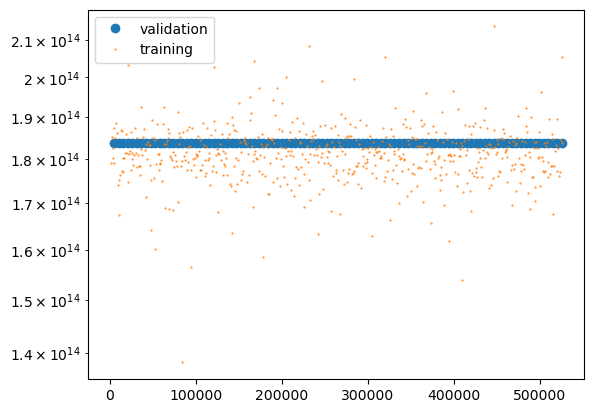

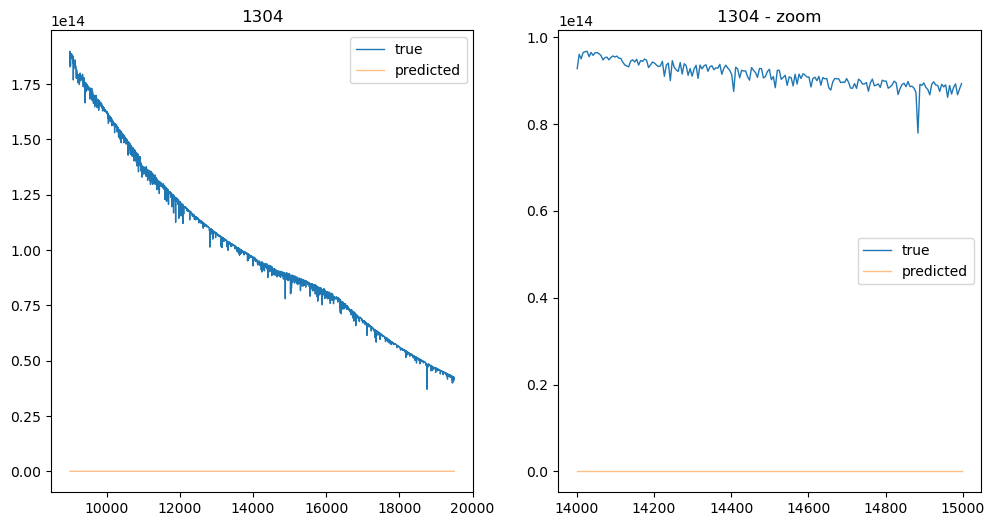

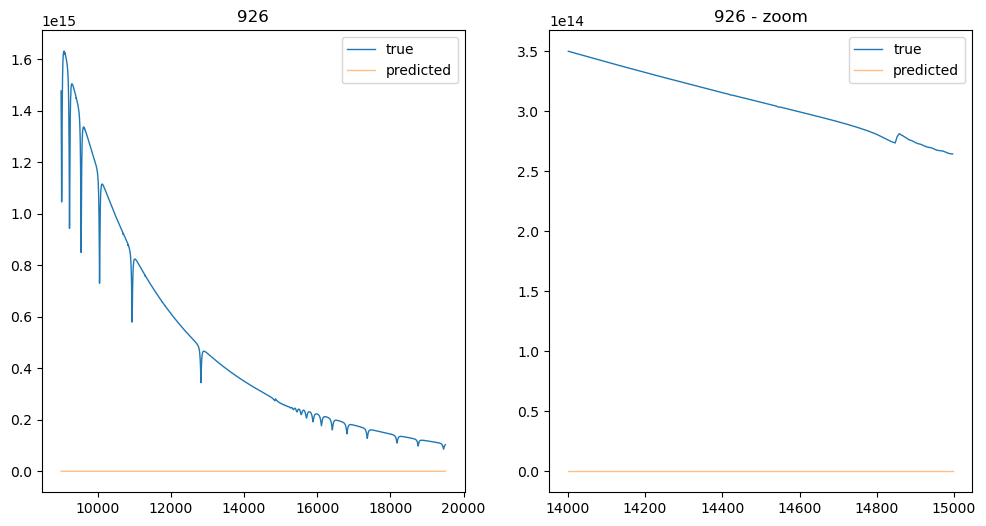

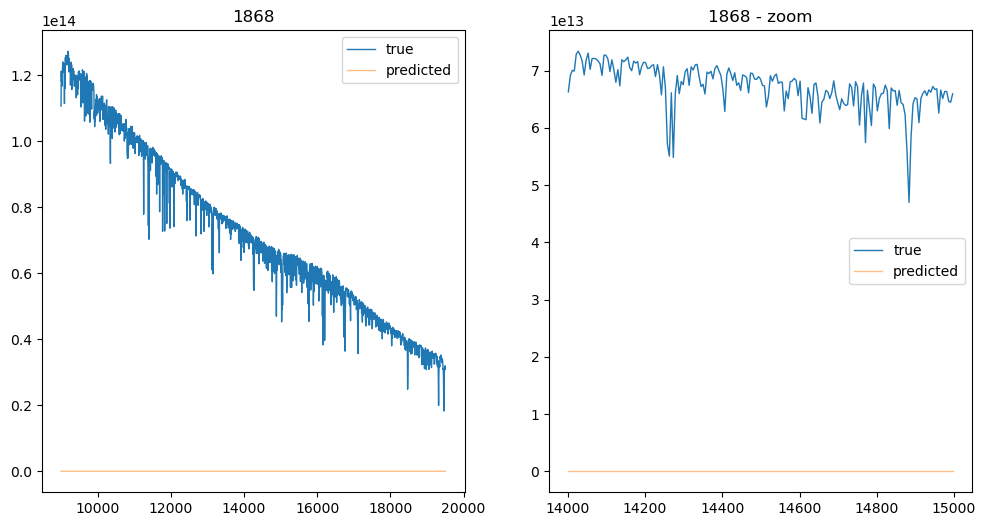

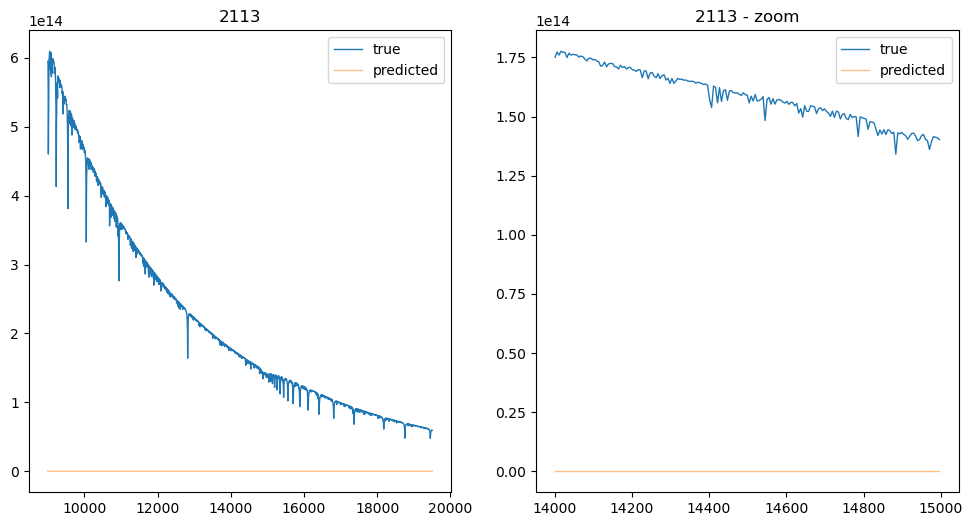

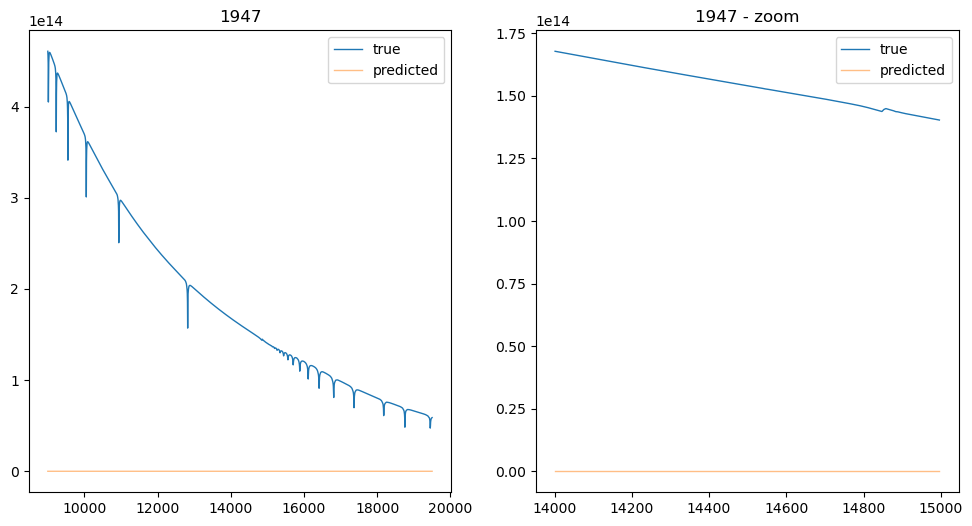

In [14]:
model = MLP().to(device, tensor_dtype)

valid, train, data_split = train_validation(model, dataset=xy_ds, nepochs=100, batch_size=1024, lr=1e-2, weight_decay=1e-3, loss_fcn=nn.L1Loss())

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')
    

This rescaling probably won't work in practice because it's a different rescaling for each spectrum...

In [15]:
indiv_rescaled_fluxes = []
for f in fluxes:
    indiv_rescaled_fluxes.append((f-f.mean())/f.std())

indiv_rescaled_fluxes = torch.stack(indiv_rescaled_fluxes)

In [16]:
xy_ds2 = TensorDataset(infeatures.to(device, tensor_dtype), indiv_rescaled_fluxes.to(device, tensor_dtype))

  0%|          | 0/100 [00:00<?, ?it/s]

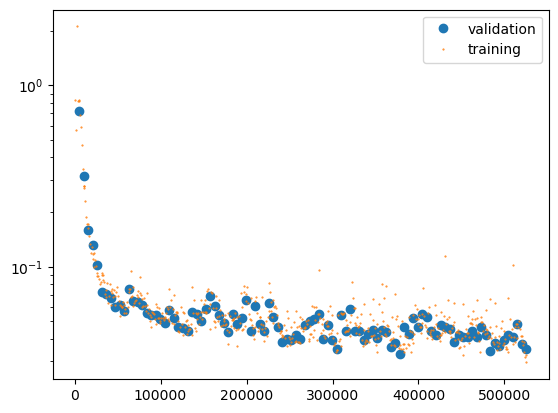

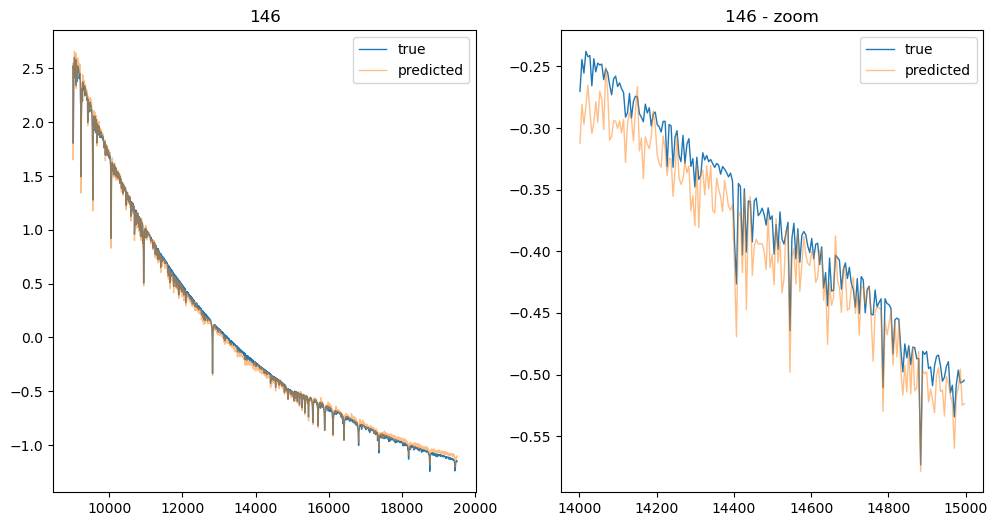

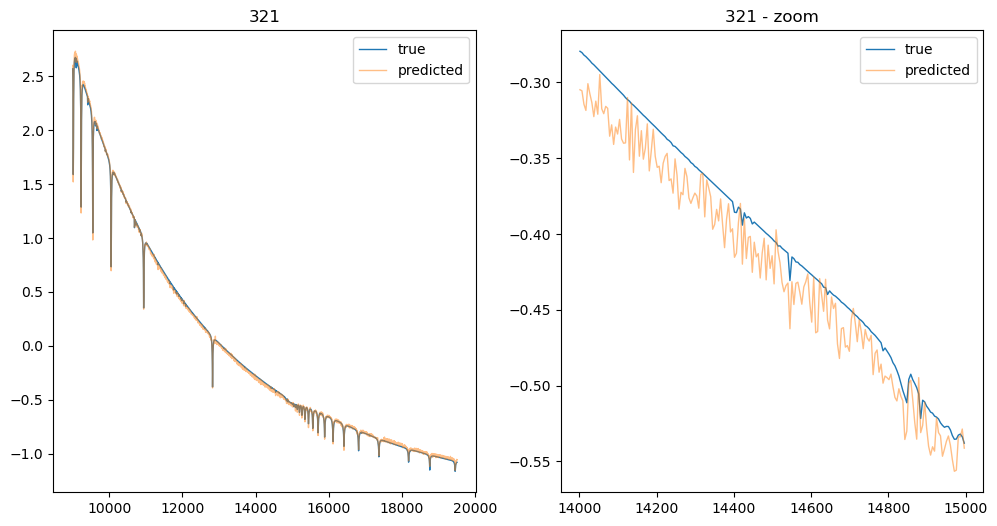

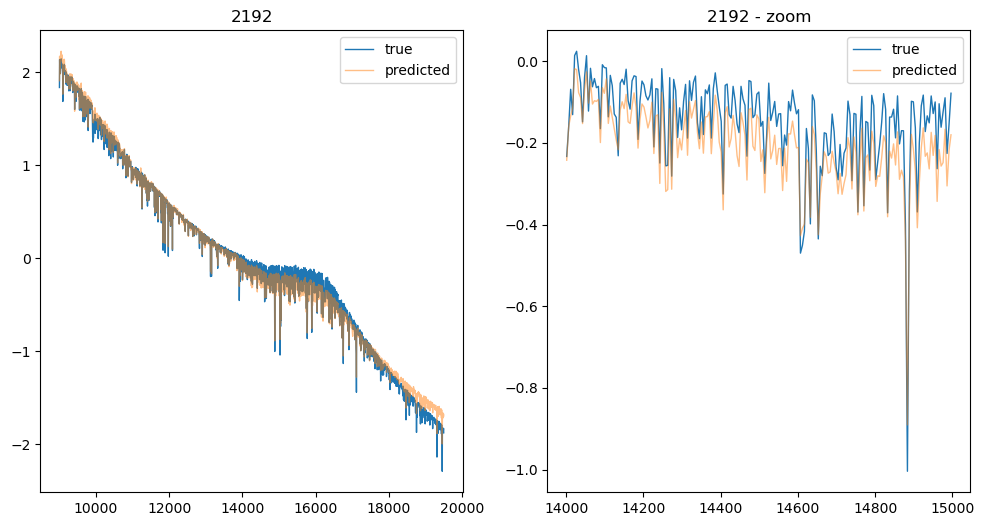

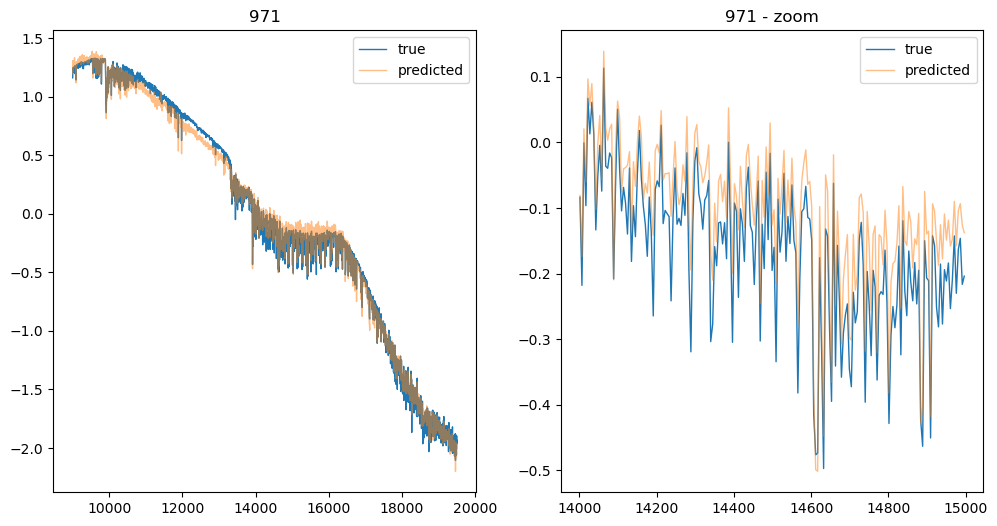

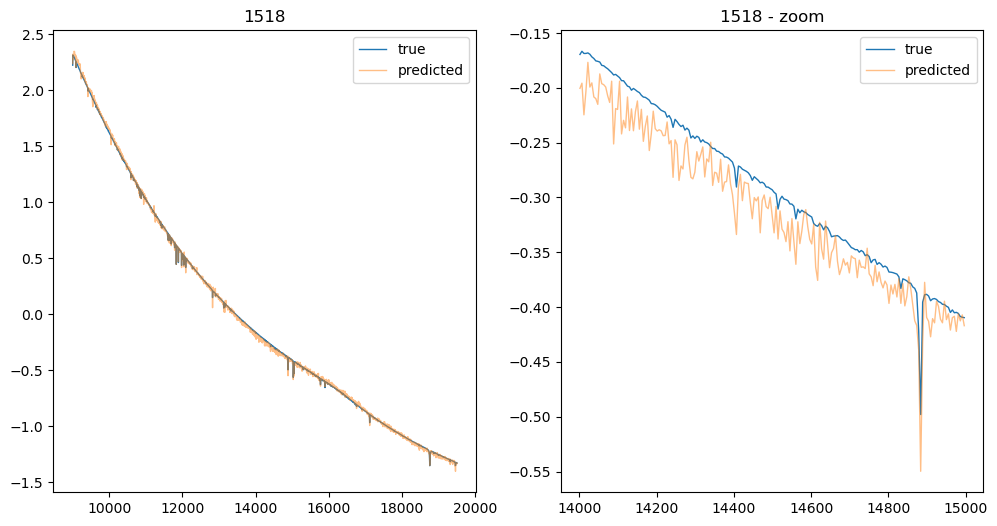

In [17]:
model = MLP().to(device, tensor_dtype)

valid, train, data_split = train_validation(model, dataset=xy_ds2, nepochs=100, batch_size=1024, lr=1e-2, weight_decay=1e-3, loss_fcn=nn.L1Loss())

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')
    

  0%|          | 0/100 [00:00<?, ?it/s]

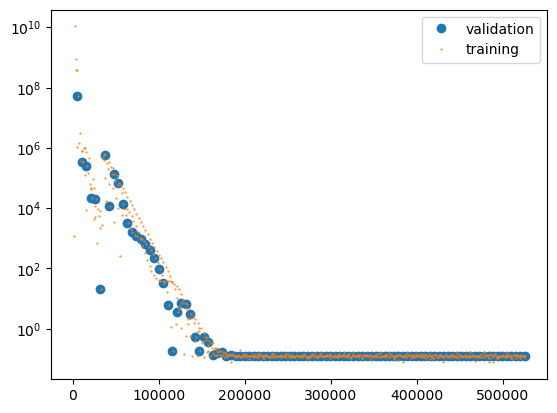

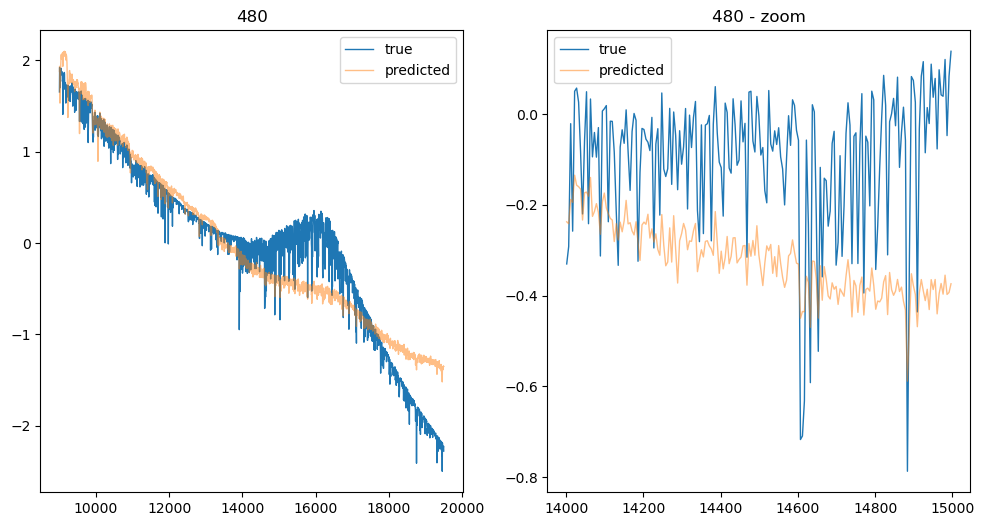

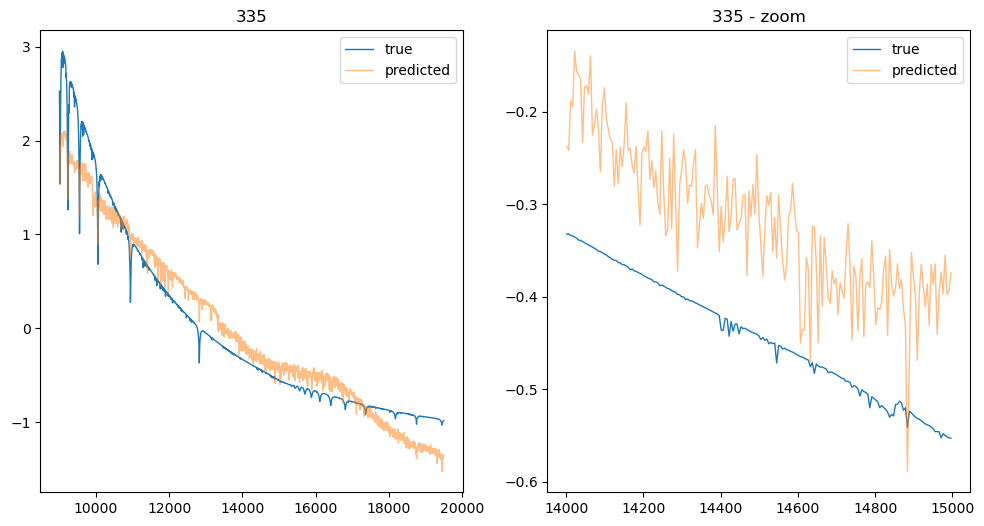

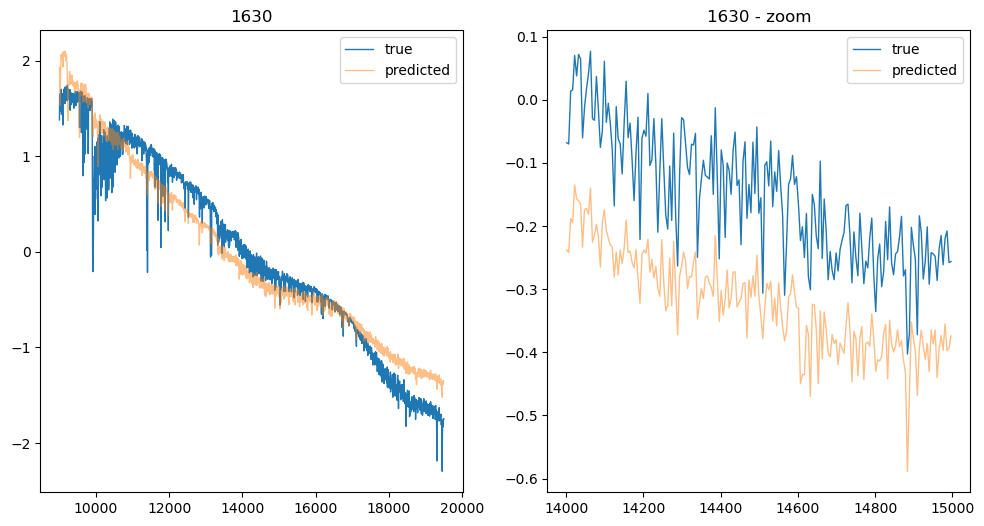

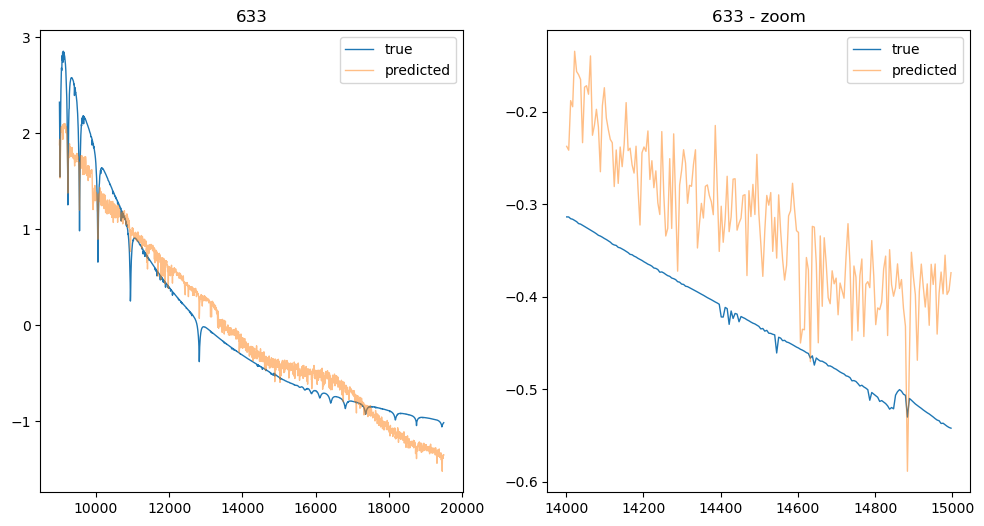

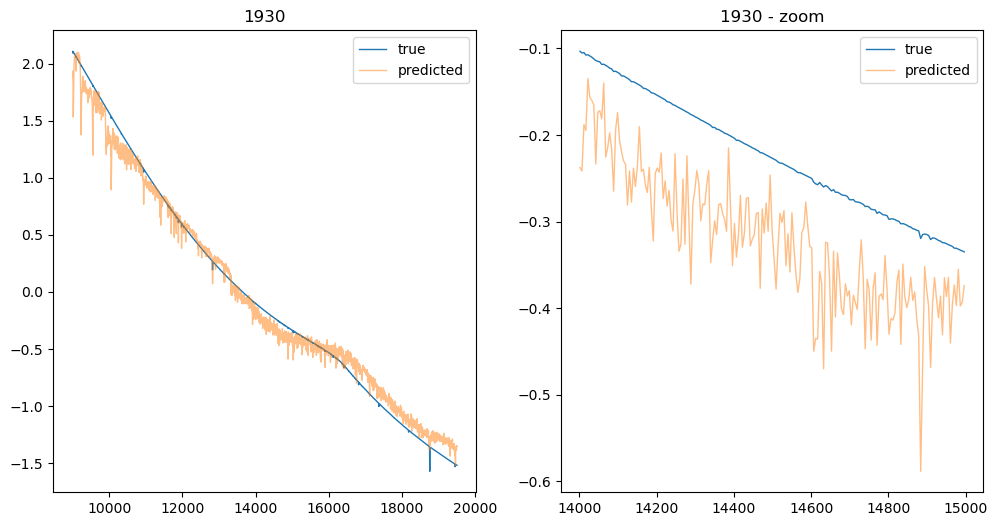

In [18]:
model = MLP( inner_layer_nneurons=[9, 81, 729, 2916], batchnorm=None).to(device, tensor_dtype)

valid, train, data_split = train_validation(model, dataset=xy_ds2, nepochs=100, batch_size=1024, lr=.1, weight_decay=1e-3, loss_fcn=nn.MSELoss())

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')
    

  0%|          | 0/100 [00:00<?, ?it/s]

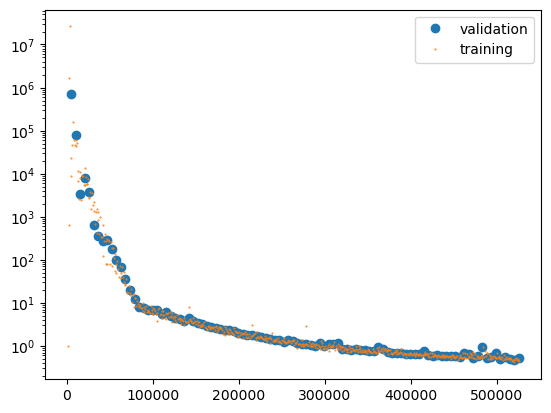

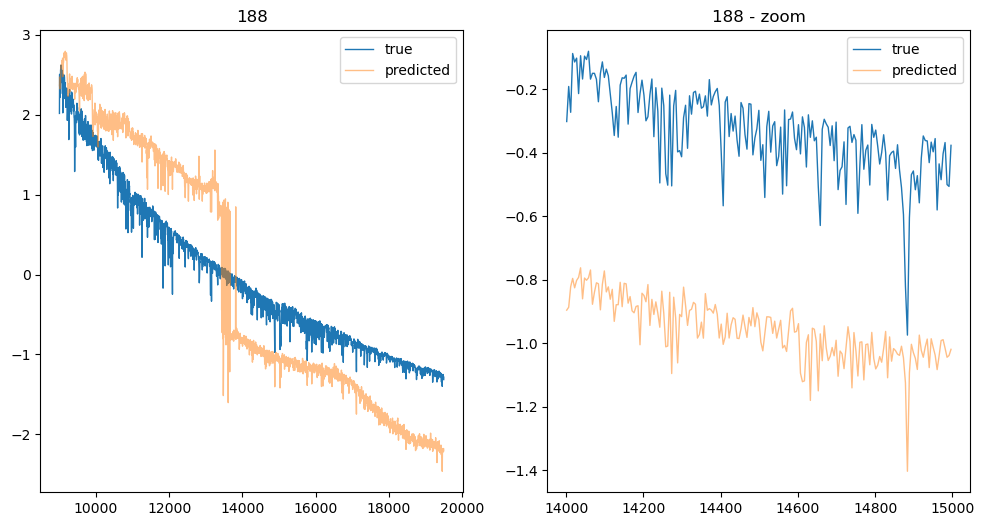

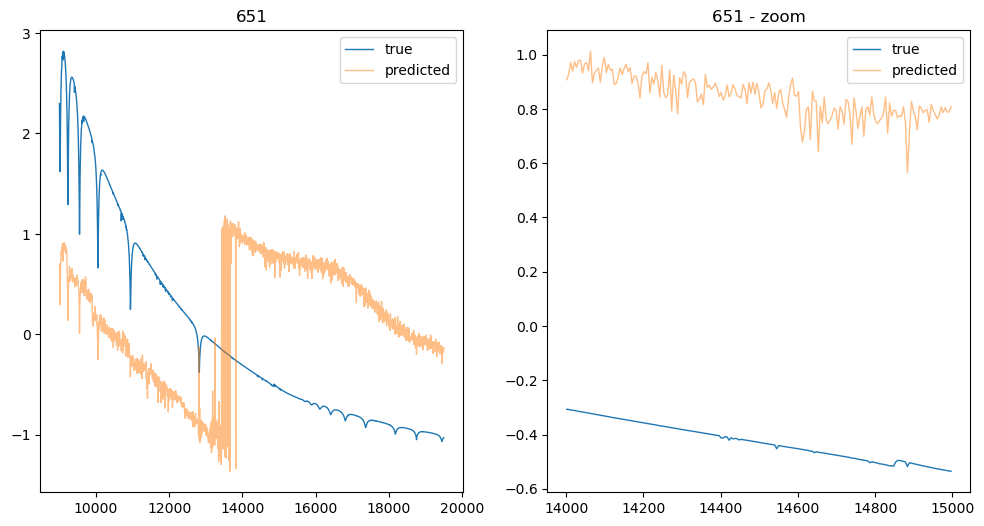

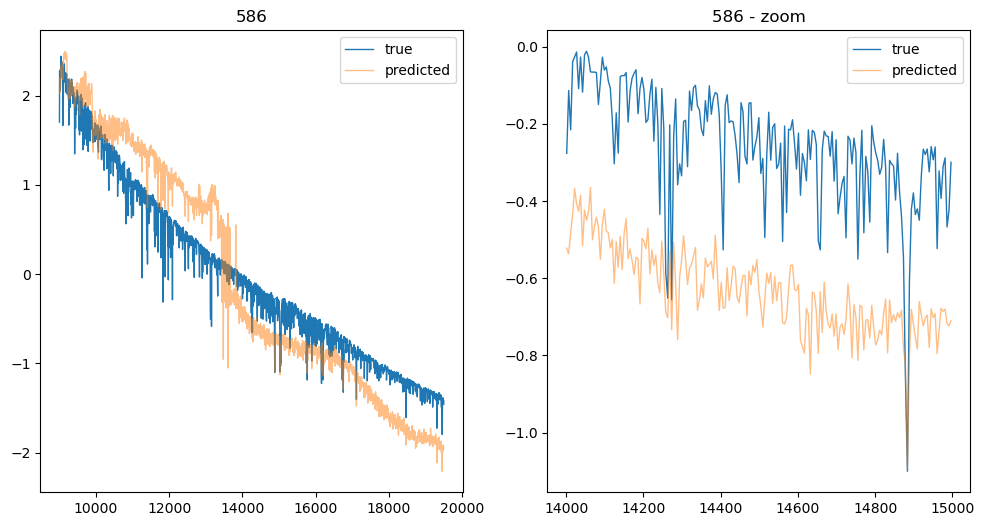

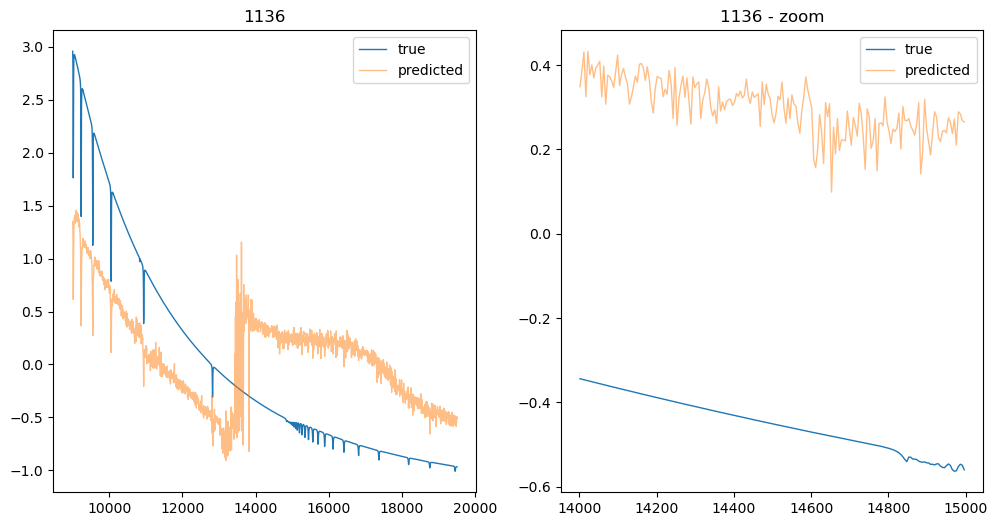

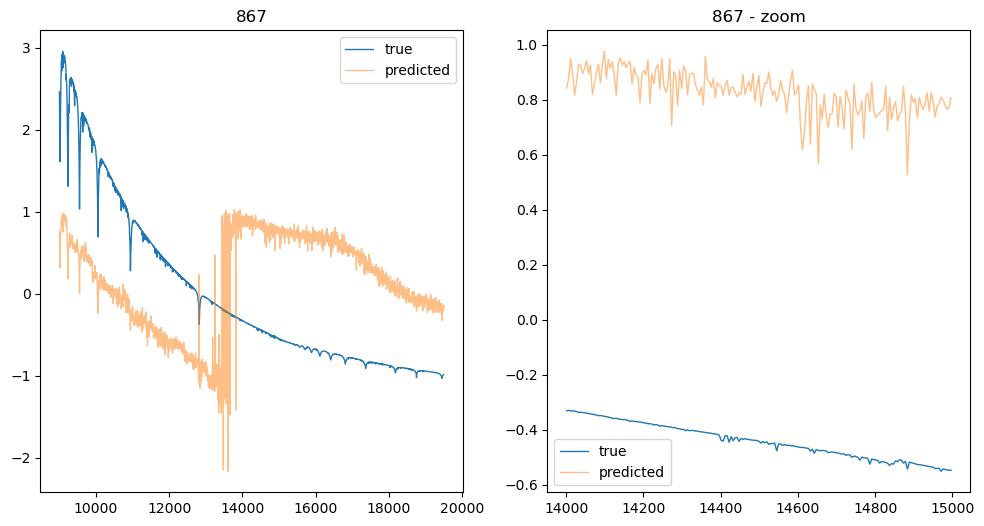

In [20]:
model = MLP( inner_layer_nneurons=[9, 81, 729, 2916], batchnorm='firstonly').to(device, tensor_dtype)

valid, train, data_split = train_validation(model, dataset=xy_ds2, nepochs=100, batch_size=1024, lr=.1, weight_decay=1e-3, loss_fcn=nn.MSELoss())

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')
    

  0%|          | 0/100 [00:00<?, ?it/s]

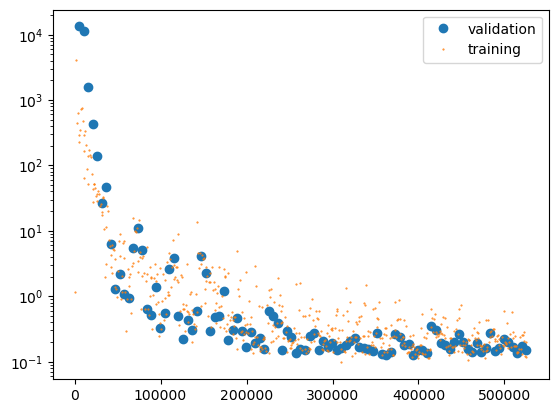

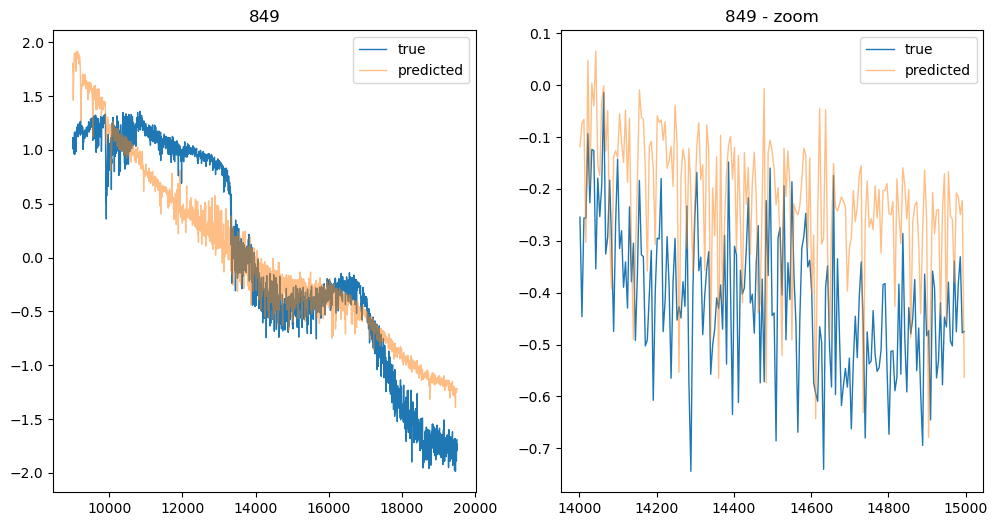

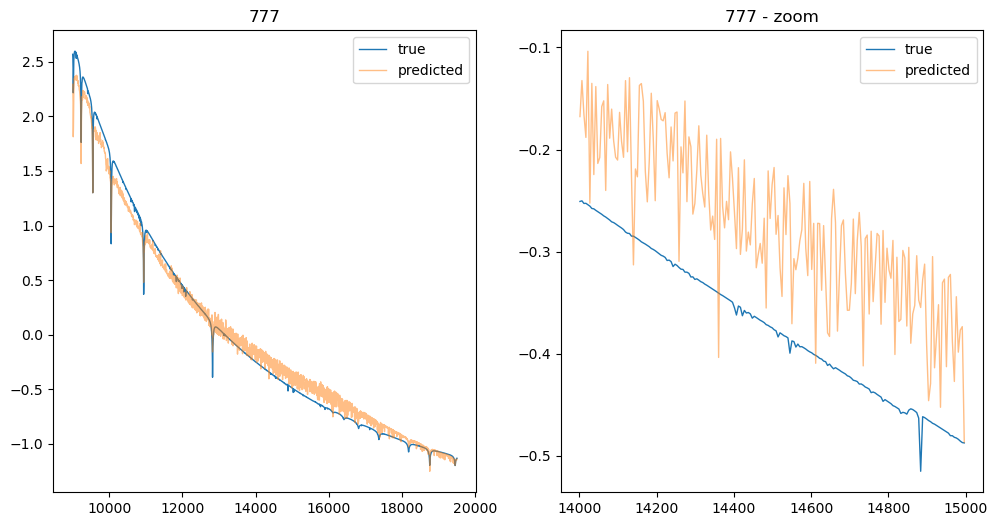

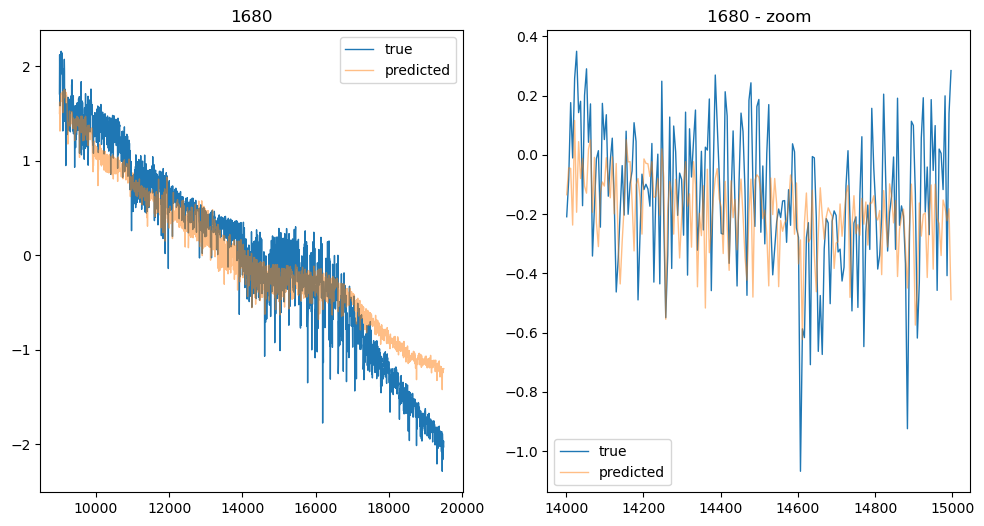

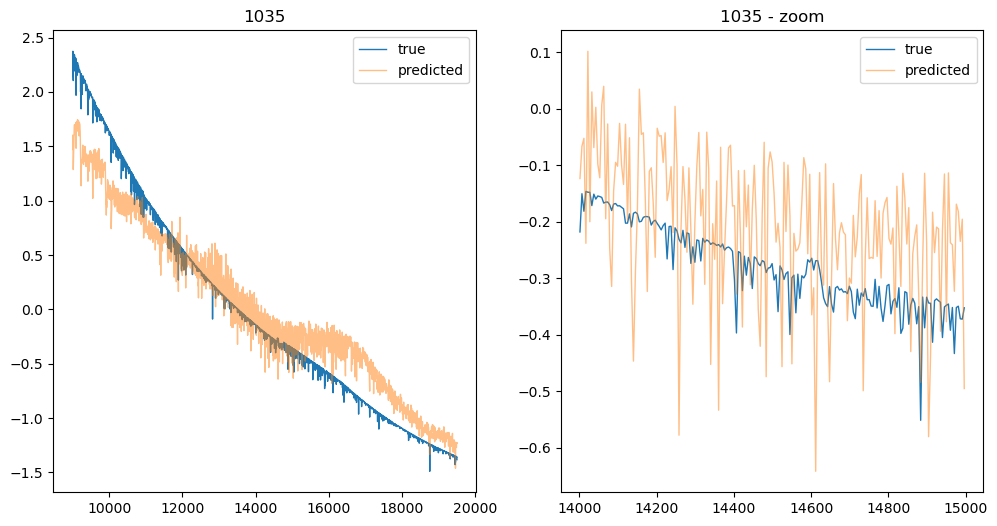

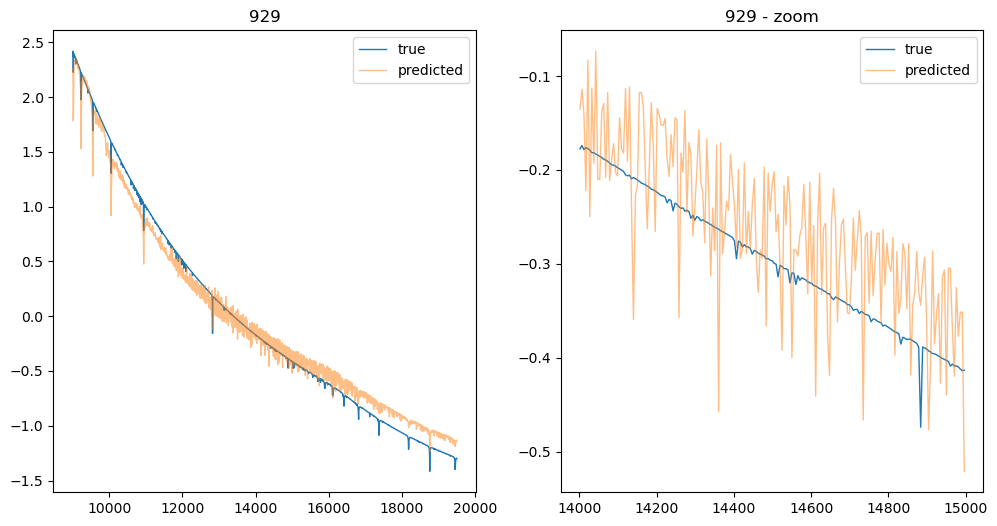

In [21]:
model = MLP( inner_layer_nneurons=[9, 81, 729, 2916], batchnorm='all').to(device, tensor_dtype)

valid, train, data_split = train_validation(model, dataset=xy_ds2, nepochs=100, batch_size=1024, lr=.1, weight_decay=1e-3, loss_fcn=nn.MSELoss())

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')
    

What about rescaling the *inputs* as well and no batchnorm?

In [24]:
rescaled_infeatures = []
for inf in infeatures.T:
    rescaled_infeatures.append((inf-inf.mean())/inf.std())
rescaled_infeatures = torch.stack(rescaled_infeatures).T

In [28]:
xy_ds3 = TensorDataset(rescaled_infeatures.to(device, tensor_dtype), indiv_rescaled_fluxes.to(device, tensor_dtype))

  0%|          | 0/100 [00:00<?, ?it/s]

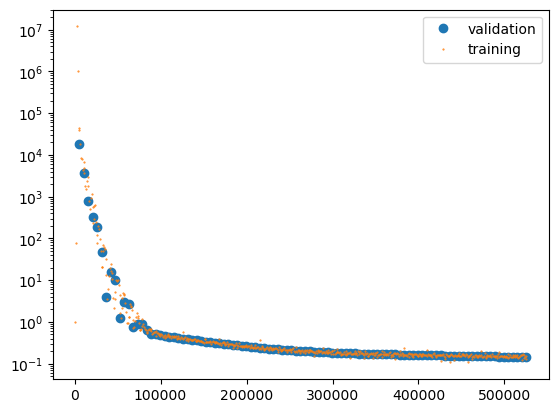

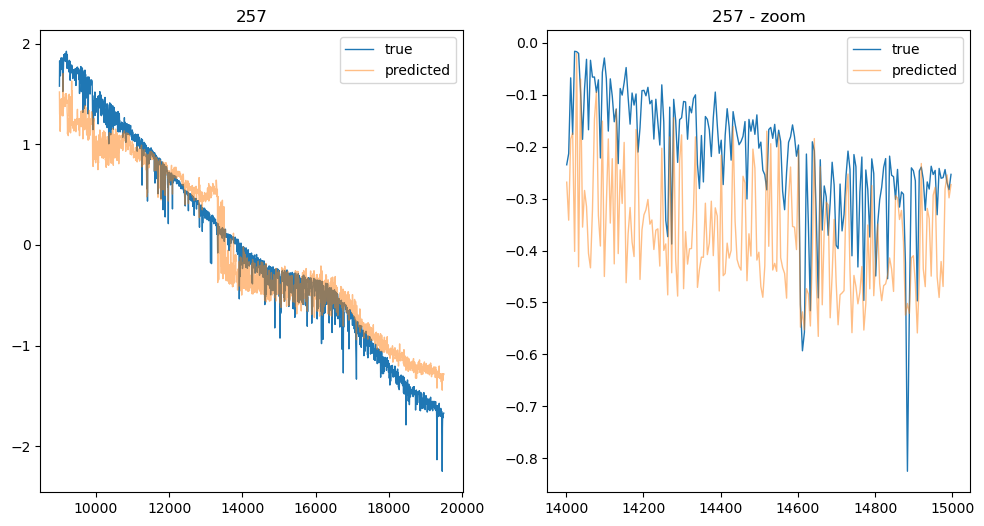

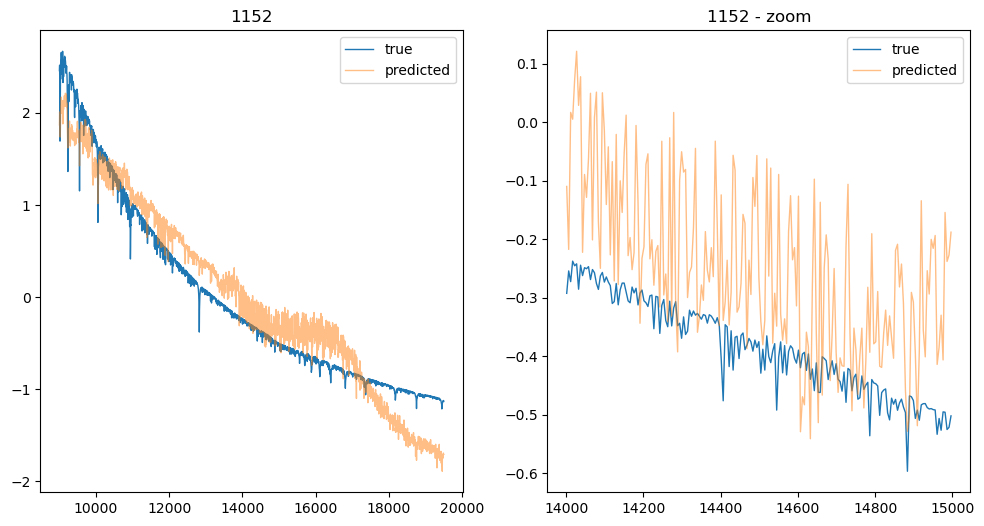

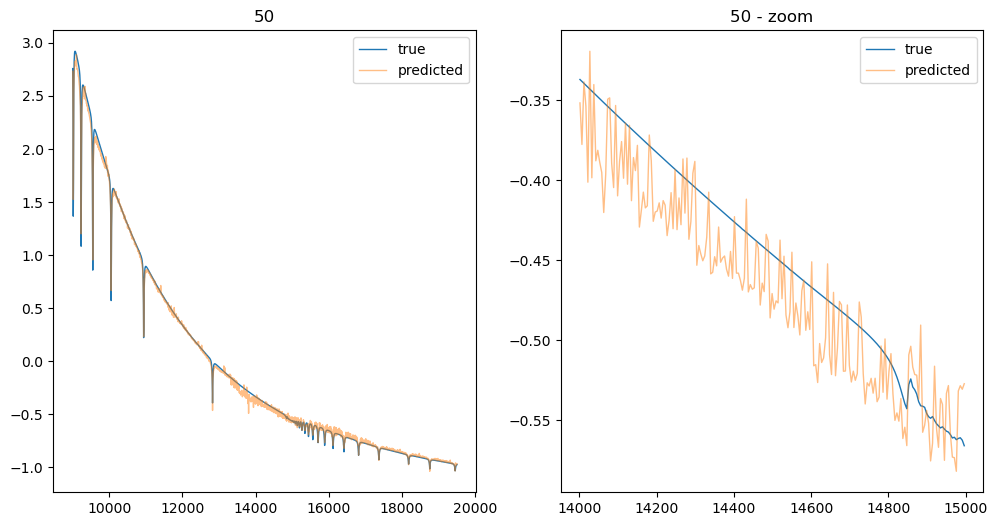

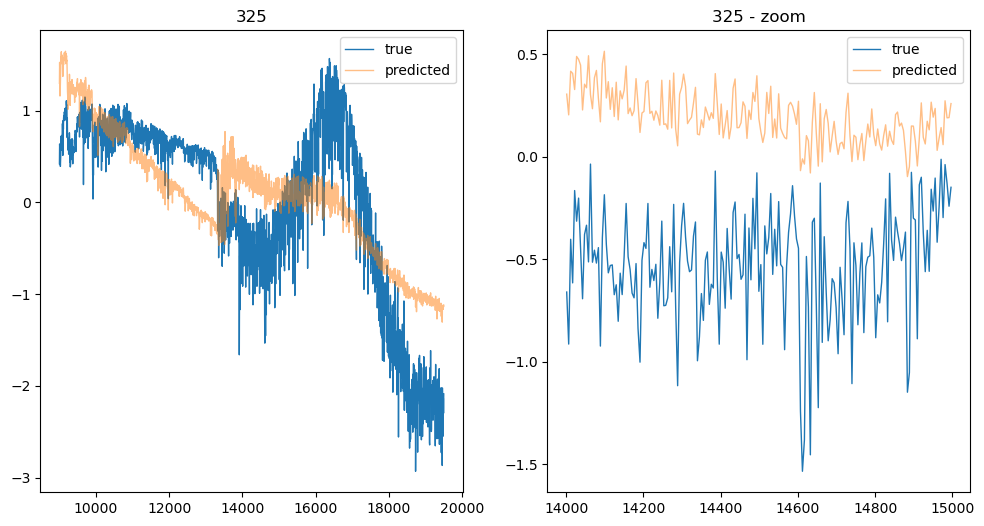

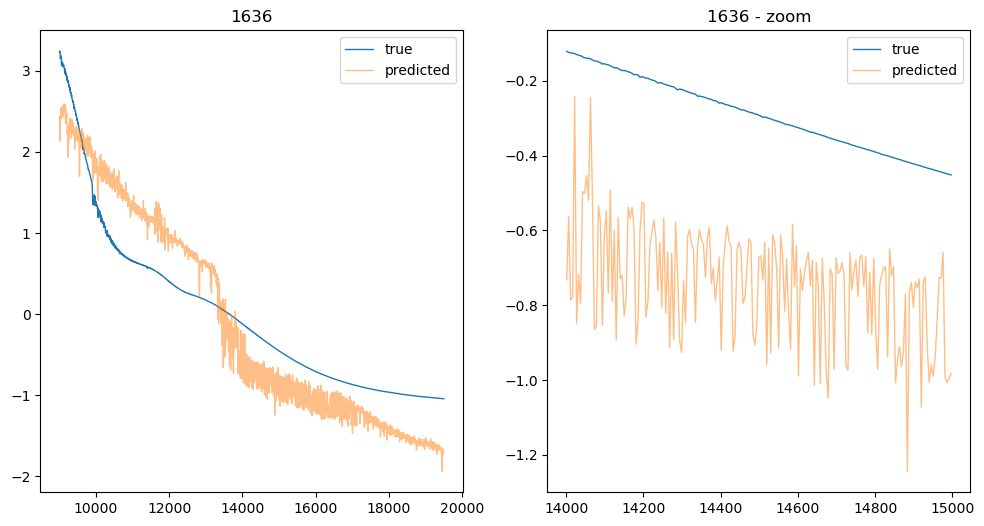

In [34]:
model = MLP( inner_layer_nneurons=[9, 81, 729, 2916], batchnorm=None).to(device, tensor_dtype)

valid, train, data_split = train_validation(model, dataset=xy_ds3, nepochs=100, batch_size=1024, lr=.1, weight_decay=1e-3, loss_fcn=nn.MSELoss())

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')
    

Try a learning schedule?

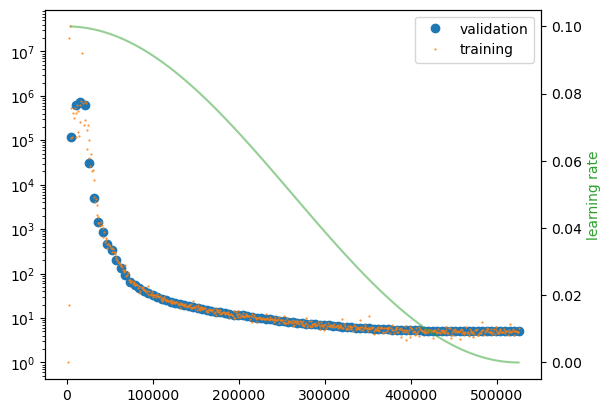

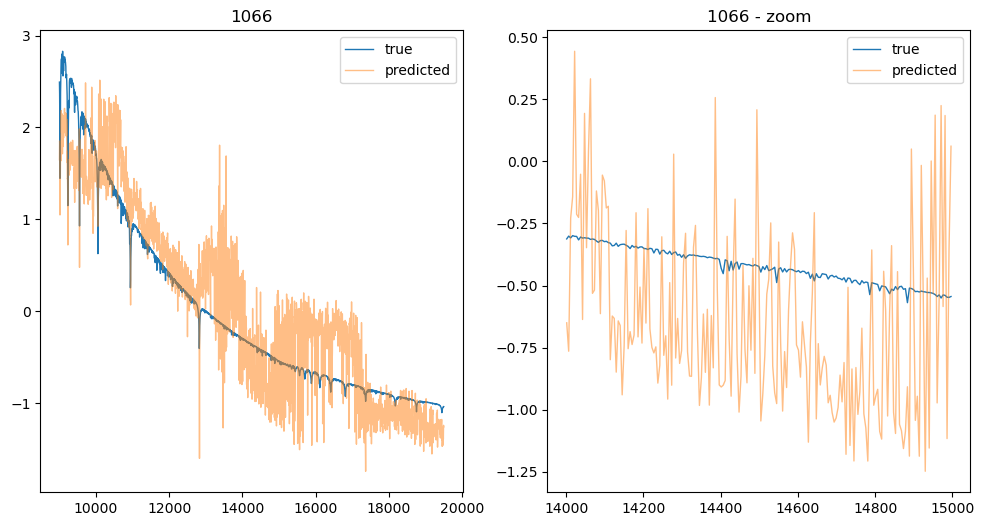

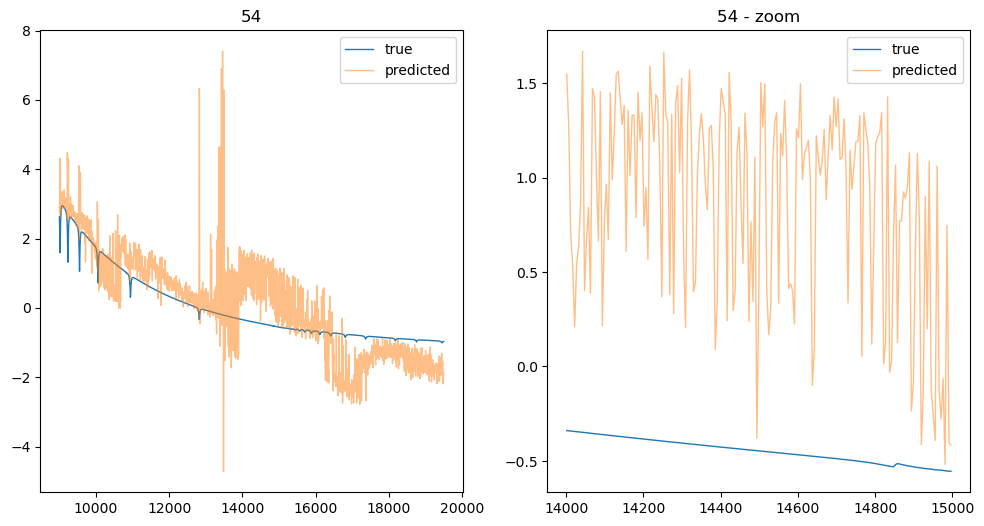

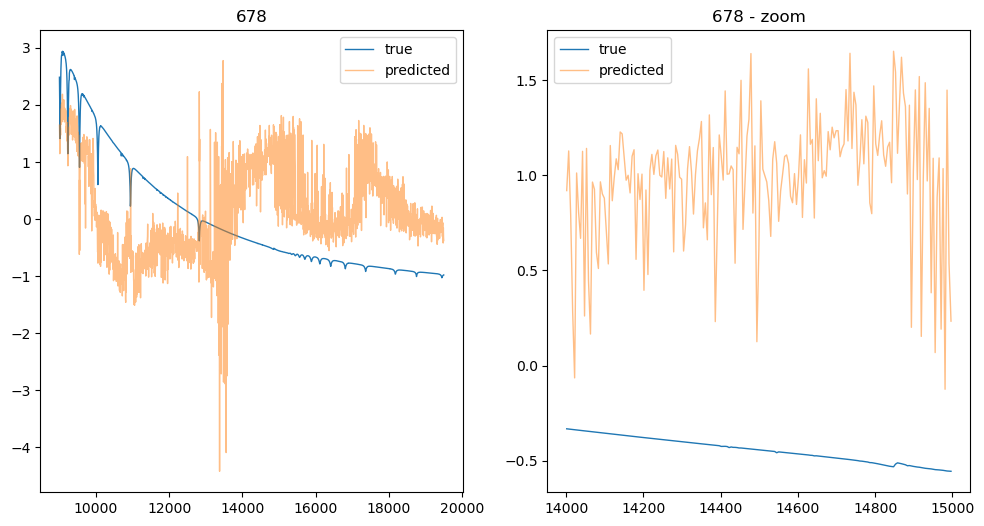

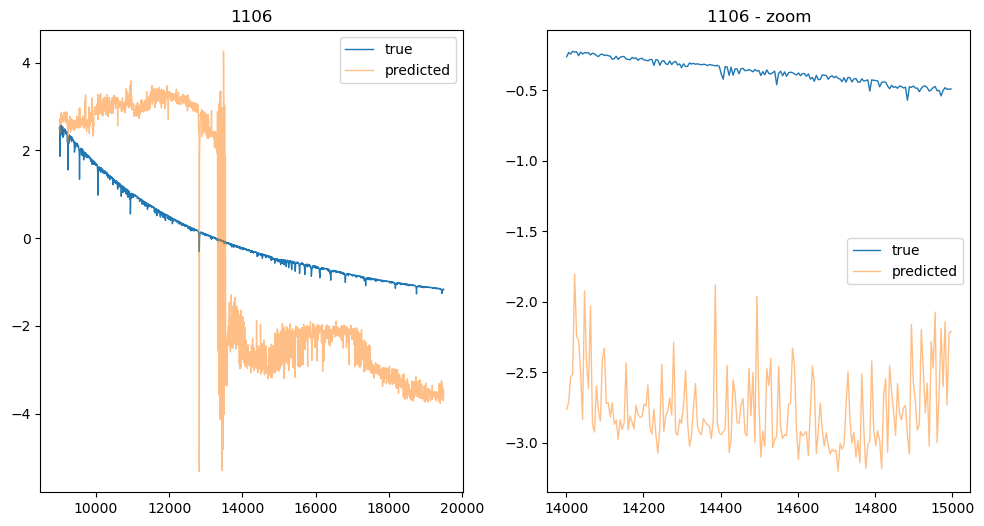

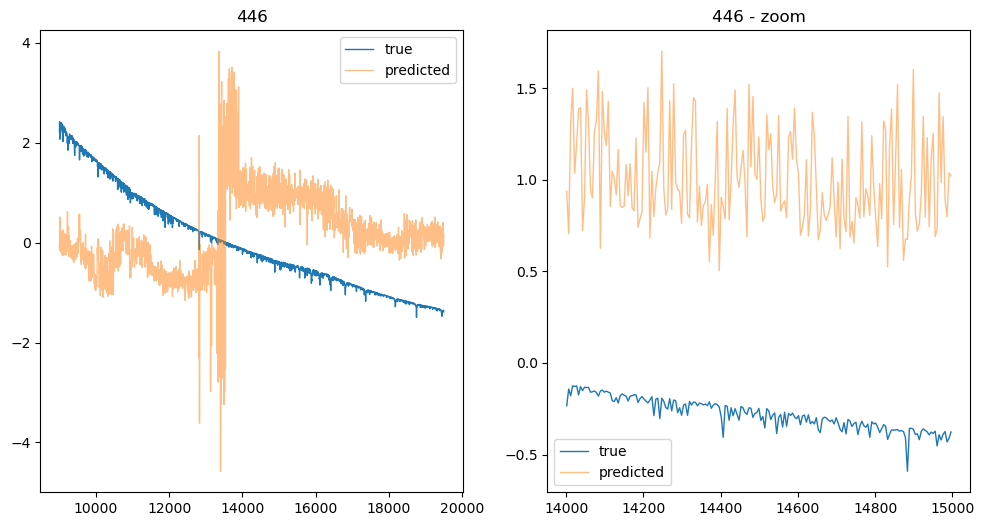

In [60]:
model = MLP( inner_layer_nneurons=[9, 81, 729, 2916], batchnorm=None).to(device, tensor_dtype)

nepochs = 100
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingLR, T_max=nepochs)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=xy_ds3, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=.1, 
                                            weight_decay=1e-3, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')

  0%|          | 0/100 [00:00<?, ?it/s]

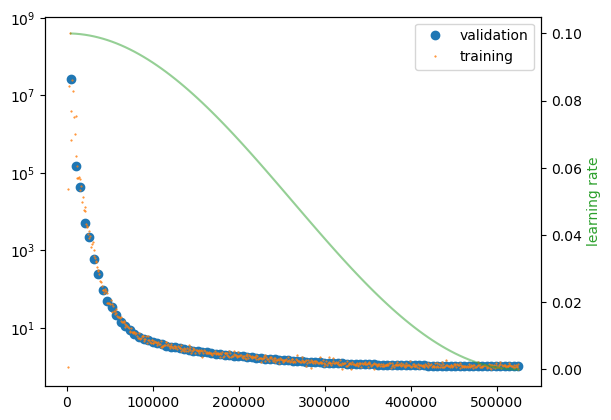

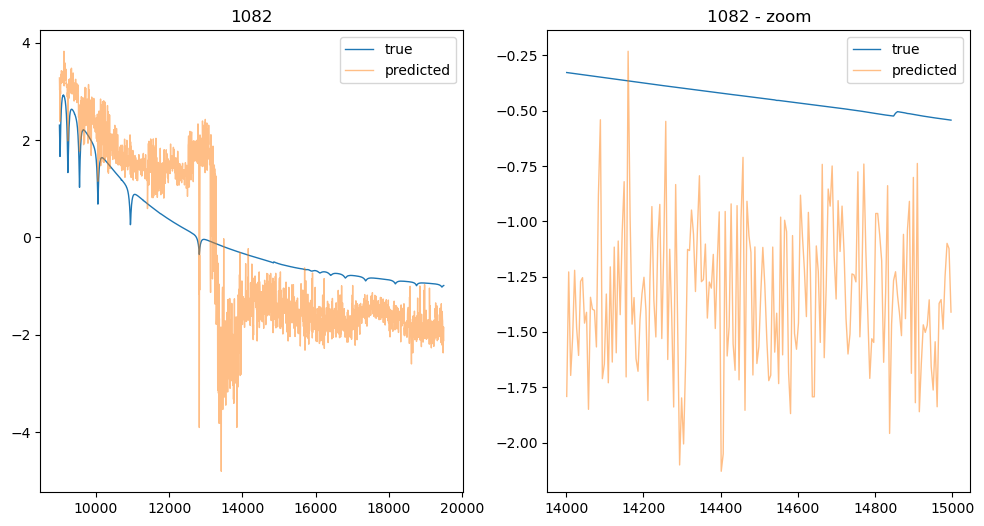

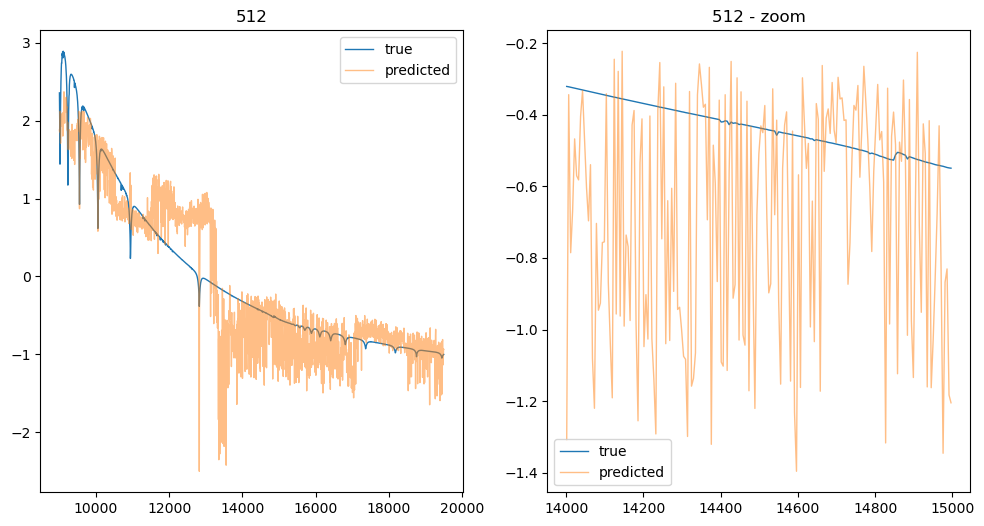

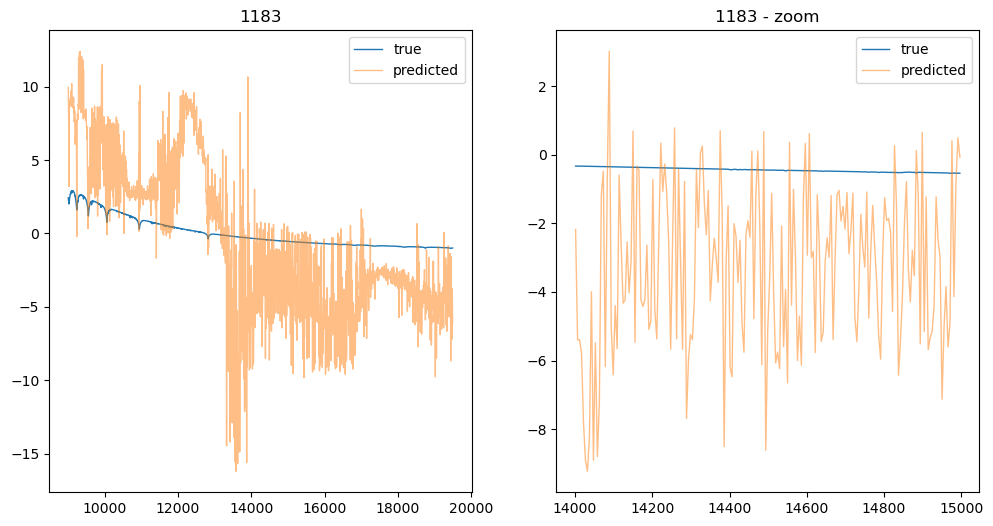

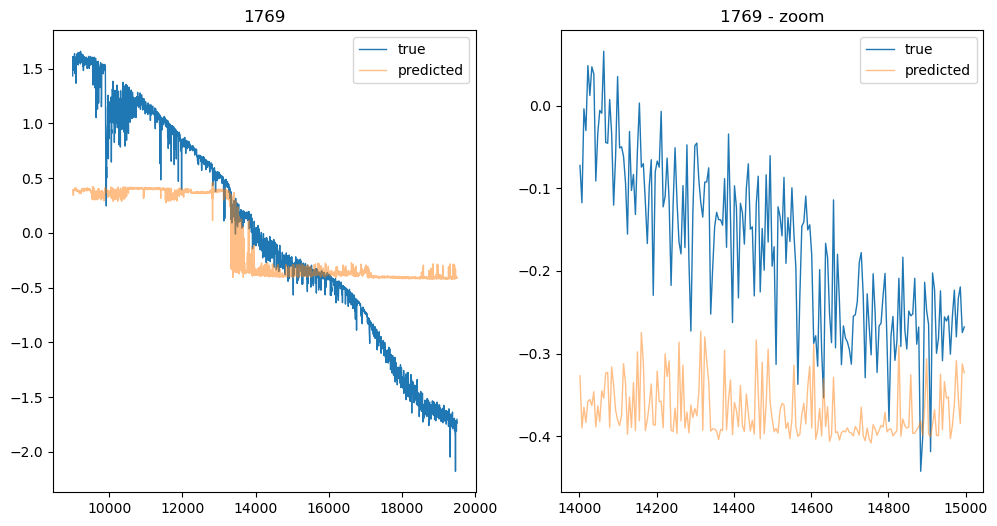

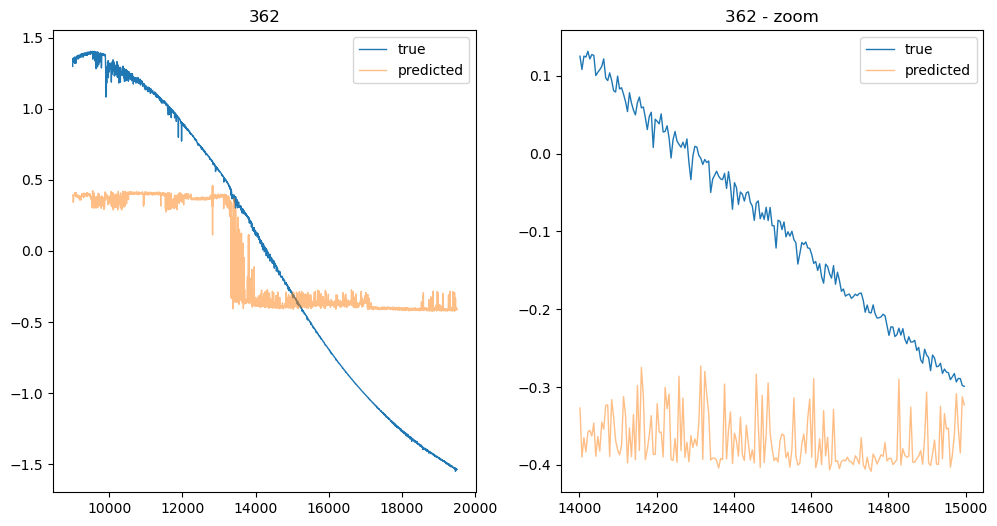

In [65]:
model = MLP(inner_layer_nneurons=[50, 1000, 10000], batchnorm=None).to(device, tensor_dtype)

nepochs = 100
sched = functools.partial(torch.optim.lr_scheduler.CosineAnnealingLR, T_max=nepochs)
valid, train, lrs, data_split = train_validation(model, 
                                            dataset=xy_ds3, 
                                            nepochs=nepochs, 
                                            batch_size=1024, 
                                            lr=.1, 
                                            weight_decay=1e-3, 
                                            loss_fcn=nn.MSELoss(), 
                                            scheduler_fcn=sched)

plt.figure()
plt.semilogy(*valid, 'o', c='C0', label='validation')
plt.semilogy(*train, '.', c='C1', ms=1, label='training')
plt.legend(loc=0)
plt.twinx()
plt.plot(valid[0], lrs, label='learning rate',c='C2', alpha=.5)
plt.ylabel('learning rate', color='C2')


valid_data, train_data = data_split
valid_idxs = np.random.randint(len(valid_data), size=5)

for valid_idx in valid_idxs:
    Xi, Yi = [xy[valid_data.indices[valid_idx]] for xy in valid_data.dataset.tensors]
    
    pred = model(Xi[None,...])[0].detach()
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axs
    
    ax1.plot(wl, Yi.cpu(), lw=1, label='true')
    ax1.plot(wl, pred.cpu(), lw=1, label='predicted', alpha=.5)
    ax1.legend(loc=0)
    ax1.set_title(f'{valid_idx}')
    
    msk = (14000<wl)&(wl<15000)
    ax2.plot(wl[msk], Yi[msk].cpu(), lw=1, label='true')
    ax2.plot(wl[msk], pred[msk].cpu(), lw=1, label='predicted', alpha=.5)
    ax2.legend(loc=0)
    ax2.set_title(f'{valid_idx} - zoom')